### 代码实现

In [1]:
# 导入必要的库
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset # 用于构造数据加载器
from torch.utils.data import random_split # 用于划分数据集

### 数据生成

In [2]:
# 定义函数
def f(x, y):
    return x ** 2 + 2 * y ** 2

# 定义初始值
num_samples = 1000 # 1000个样本点
X = torch.rand(num_samples) # 均匀分布
Y = torch.rand(num_samples) # 均匀分布
Z = f(X,Y) + 3 * torch.randn(num_samples)

dataset = torch.stack([X, Y, Z], dim = 1)

### 数据划分

In [3]:
# 按照7：3划分数据集
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_size, test_size])

# 将数据封装成数据加载器
train_dataloader = DataLoader(TensorDataset(train_dataset.dataset.narrow(1,0,2), train_dataset.dataset.narrow(1,2,1)), batch_size=32)
test_dataloader = DataLoader(TensorDataset(test_dataset.dataset.narrow(1,0,2), test_dataset.dataset.narrow(1,2,1)), batch_size=32)

### 模型定义

In [4]:
# 定义一个简单模型
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)

### 模型训练对比

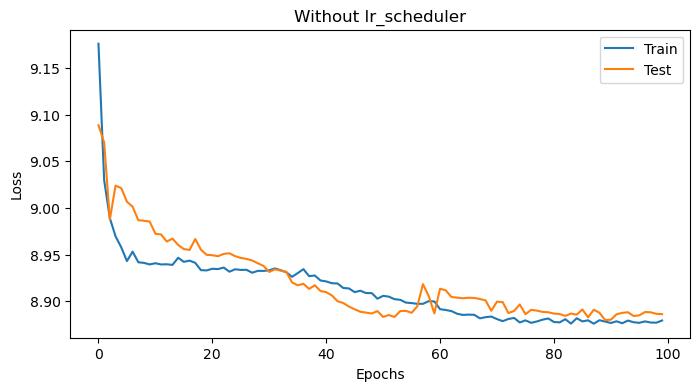

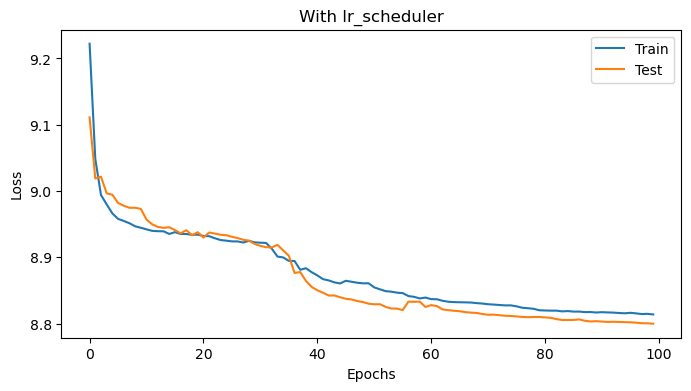

In [5]:
# 超参数
num_epochs = 100
learning_rate = 0.1 # 学习率，故意调大一些更直观

# 定义损失函数
loss_fn = nn.MSELoss()

# 通过一个训练对比有无学习率调节器的效果
for with_scheduler in [False, True]:

    # 定义训练和测试误差数组
    train_losses = []
    test_losses = []

    # 初始化模型
    model = Model()

    # 定义优化器
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # 定义学习率调节器
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    # 迭代训练
    for epoch in range(num_epochs):
        # 在训练数据上迭代
        model.train()
        train_loss = 0
        # 遍历训练集
        for inputs, targets in train_dataloader:
            # 预测、损失函数、反向传播
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            # 记录loss
            train_loss += loss.item()

        # 计算loss并记录到训练误差
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # 在测试数据上评估，测试模型不计算梯度
        model.eval()
        test_loss = 0
        with torch.no_grad():
            # 遍历测试集
            for inputs, targets in test_dataloader:
                # 预测、损失函数
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                # 记录loss
                test_loss += loss.item()

            # 计算loss并记录到测试误差
            test_loss /= len(test_dataloader)
            test_losses.append(test_loss)

        # 是否更新学习率
        if with_scheduler:
            scheduler.step()
    
    # 绘制训练和测试误差曲线
    plt.figure(figsize=(8, 4))
    plt.plot(range(num_epochs), train_losses, label="Train")
    plt.plot(range(num_epochs), test_losses, label="Test")
    plt.title("{0} lr_scheduler".format("With" if with_scheduler else "Without"))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

### 常见学习率调节器

In [6]:
# 学习率衰减，例如每训练100次就将学习率降低为原来的一半
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [7]:
# 指数衰减法，每次迭代将学习率乘上一个衰减率
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [8]:
# 余弦学习率调节，optimizer初始学习率为最大学习率，eta_min是最小学习率，T_max是最大迭代次数
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.00001)

In [9]:
# 自定义学习率，通过一个lambda函数实现自定义的学习率调节器
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.99 ** epoch)

In [10]:
# 预热
warmup_steps = 20
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda t: min(t / warmup_steps, 0.001))